In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv("../data/Bone Mineral Density.txt", sep='\t')
df.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


In [3]:
x_male = df[df.gender == 'male'].age.values
y_male = df[df.gender == 'male'].spnbmd.values
x_female = df[df.gender == 'female'].age.values
y_female = df[df.gender == 'female'].spnbmd.values
x_min, x_max = df.age.min(), df.age.max()

In [4]:
def dk(x, xi_k, xi_K):
    return (max(0, x-xi_k)**3) / (xi_K-xi_k)

def do_nc_expansion(x, xis):
    X = np.zeros(shape=(x.shape[0], len(xis)))
    for i in range(X.shape[0]):
        X[i, 0] = 1
        X[i, 1] = x[i]
        for k in range(2, len(xis)):
            X[i, k] = dk(x[i], xis[k-2], xis[-1]) - dk(x[i], xis[-2], xis[-1])
    return X

In [5]:
x_unique_male = np.unique(x_male)
N_male = do_nc_expansion(x_male, x_unique_male)
x_unique_female = np.unique(x_female)
N_female = do_nc_expansion(x_female, x_unique_female)

In [6]:
ls_male = sm.OLS(y_male, N_male).fit_regularized(alpha=0.00022, L1_wt=0)
ls_female = sm.OLS(y_female, N_female).fit_regularized(alpha=0.00022, L1_wt=0)

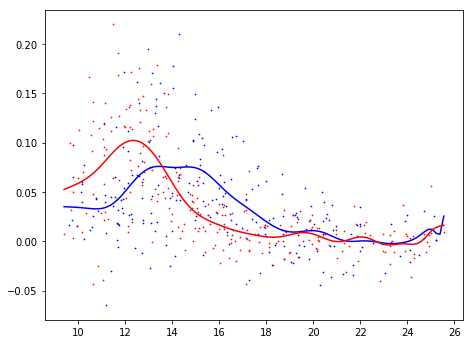

In [7]:
plt.figure(figsize=(7.5,5.7))
x = np.linspace(x_min, x_max, 100)
y_male_hat = ls_male.predict(do_nc_expansion(x, x_unique_male))
y_female_hat = ls_female.predict(do_nc_expansion(x, x_unique_female))
plt.scatter(x_male, y_male, s=0.5, color='blue')
plt.plot(x, y_male_hat, color='blue')
plt.scatter(x_female, y_female, s=0.5, color='red')
plt.plot(x, y_female_hat, color='red')

In [8]:
def a_ij(i, j, a):
    return (a[-1]-a[i]) * (a[-1]-a[j])
def integral_formula(x, i, j, a):
    return (1/a_ij(i, j, a)) * (1/3*(x**3) - 1/2*(x**2)*(a[i]+a[j])+x*a[i]*a[j])
def integral_value(i, j, a):
    xs, xf = a[max(i, j)], a[-1]
    return integral_formula(xf, i, j, a) - integral_formula(xs, i, j, a)
def N_ij(i, j, k, a):
    return 36*(integral_value(i, j, a) - integral_value(i, k-1, a) - integral_value(j, k-1, a) + integral_value(k-1, k-1, a))

In [9]:
def calc_O(x_unique, N):
    O = np.zeros(shape=(N.shape[1], N.shape[1]))
    k = x_unique.shape[0]-1
    for i in range(O.shape[0]):
        for j in range(O.shape[1]):
            if i <= 1 or j <= 1:
                continue
            O[i, j] = N_ij(i-2, j-2, k, x_unique)    
    return O

In [10]:
O_male = calc_O(x_unique_male, N_male)
O_female = calc_O(x_unique_female, N_female)

In [33]:
np.sum(O_male)

2052227.604651446

In [12]:
theta_male_hat = np.linalg.inv(N_male.T @ N_male + 0.00022*3600*O_male) @ N_male.T @ y_male
y_male_hat = do_nc_expansion(x, x_unique_male) @ theta_male_hat
theta_female_hat = np.linalg.inv(N_female.T @ N_female + 0.00022*3600*O_female) @ N_female.T @ y_female
y_female_hat = do_nc_expansion(x, x_unique_female) @ theta_female_hat

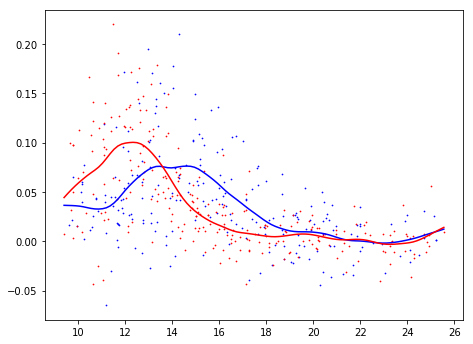

In [13]:
plt.figure(figsize=(7.5,5.7))
plt.scatter(x_male, y_male, s=0.5, color='blue')
plt.plot(x, y_male_hat, color='blue')
plt.scatter(x_female, y_female, s=0.5, color='red')
plt.plot(x, y_female_hat, color='red')

In [14]:
Sl = N_male @ np.linalg.inv(N_male.T @ N_male + 0.00022*3600*O_male) @ N_male.T

In [15]:
np.trace(Sl)

12.174187017873752